## 전력수요예측

### 목차

* 1. Data ETL (Extract, Transform, Load) <br>
    1.1 데이터 시간 index 확인 및 format 설정 <br>
    1.2 Data Quality 확인 (Missing Values, Duplicate Values etc) <br>
    1.3 도표 통해 기초 통계 정보 분석 (Trend, Seasonality etc) <br><br>
* 2. 시계열 모델 제작 (Fit Model) <br>
    2.1 모델 가정 확인 <br>
    2.2 Stationarity Test (Augmented Dickey-Fuller test, ACF/PACF 표 확인) <br>
    2.3 Seasonality 확인 <br>
    2.4 적합한 모델 종류 선택 <br>
    2.5 여러 parameter 비교 및 선택 (AIC, BIC) <br><br>
* 3. 수요 에측 (Forecast Demand)

## Data 로드

In [1]:
## module import
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import DataFrame #데이터 전처리 

from statsmodels.tsa.seasonal import seasonal_decompose # decompose
from statsmodels.tsa.stattools import adfuller # stationary test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #AutoCorrelation , Partial AutoCorrelation
import itertools # 보간
from statsmodels.tsa.arima_model import ARIMA # SARIMA랑 다른 패키지
import statsmodels.api as sm # statsmodels


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [4]:
## 'Time' column을 index로
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

In [5]:
train.shape

(16909, 1301)

> 2016년 7월 26일 11시 ~ 2018년 6월 30일 24시까지 시간 당 전력사용량

In [6]:
train.head()

,Time,X692,X1272,X553,X1299,X4,X598,X1003,X1010,X1216,X1047,X381,X466,X1420,X686,X711,X1251,X828,X1350,X1066,X1293,X1148,X451,X174,X74,X626,X1083,X1000,X632,X1380,X607,X680,X977,X492,X968,X891,X122,X489,X86,X392,X1007,X549,X1343,X437,X551,X287,X138,X339,X1210,X127,X644,X1472,X604,X1356,X173,X1399,X859,X281,X514,X345,X997,X657,X1495,X9,X894,X577,X1178,X81,X853,X1455,X494,X759,X1471,X1263,X96,...,X84,X1176,X858,X596,X1265,X1391,X715,X1419,X682,X444,X1192,X328,X171,X570,X720,X505,X34,X852,X1279,X1225,X802,X499,X440,X1166,X1431,X1482,X23,X441,X1070,X707,X493,X785,X873,X1179,X1125,X109,X224,X1259,X1143,X1324,X889,X689,X447,X1270,X827,X1037,X942,X1498,X678,X1100,X239,X1369,X436,X536,X933,X1035,X1194,X1441,X291,X1328,X1323,X616,X1195,X944,X1017,X1164,X656,X1287,X324,X767,X1271,X1288,X58,X1033,X1163
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 결측치 파악 (train,test)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


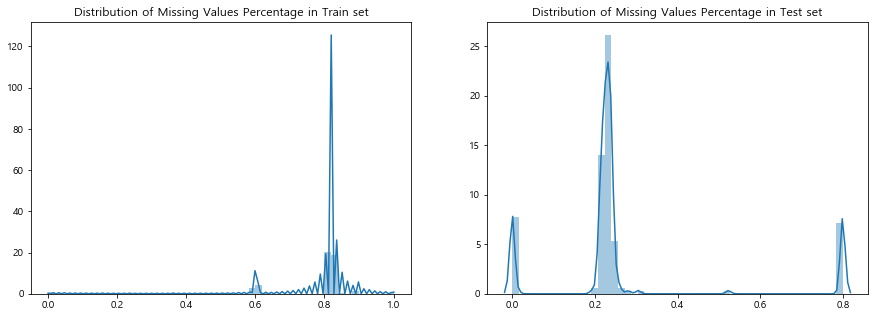

In [7]:
_, ax = plt.subplots(1,2, figsize=(15,5)) #train, test를 한 번에 비교하기 위해, 그래프 창을 2개로 만듭니다.
# train.isnull().mean(axis=0) #각 세대별 이름과 결측치 비율이 나열됩니다.
sns.distplot(train.isnull().mean(axis=0), ax=ax[0]) #나열된 값을 distplot을 이용해 시각화 하고, 이를 첫 번째 그래프 창에 넣습니다.
ax[0].set_title('Distribution of Missing Values Percentage in Train set')

sns.distplot(test.isnull().mean(axis=0), ax=ax[1]) #test data에서의 결측치 비율을 시각화 하고, 이를 두 번째 그래프 창에 넣습니다.
ax[1].set_title('Distribution of Missing Values Percentage in Test set')
plt.show()

#### 결측값 채우기

> * NA가 발생한 경우, 직전 시간의 전력사용량 값이 상당히 큰 경향이 있습니다. 이는 미터링 데이터 수집 시스템의 특징으로 볼 수 있음
* 직전 시간의 사용량이 과다가 아닌 경우의 결측값을 채우는 방법도 필요

In [8]:

for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )

    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [9]:
# Time컬럼 datetime형식으로 변환 후, 인덱스로
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time', inplace=True) # Date를 인덱스로

# 1차 결측치 제거 후 sample 데이터 추출 
# sample data => 2018-02-15 이후의 데이터 셋
train_sample = train['2018-02-15':]

# sampple데이터에서의 1차 결측치 제거 후 결측치는 시간에따른보간법으로 채움
train_sample = train_sample.interpolate(method='time')

In [10]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

Index(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'],
      dtype='object')

In [11]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

> 'X692' 세대를 대표로 모델링 , 일별 사용량 예측 테스트

In [12]:
## 일별 sampling

# 2018-02-15 ~ 2018-06-30 까지의 일별 전력수요량 합계
train_day = train_sample['X1272'].resample(rule='D').sum()
# train_day = train_sample['X692'].resample(rule='D').sum() # 월별
# train_day = train_sample['X692'].resample(rule='D').sum() # 시간별

In [13]:
train_day

Time
2018-02-15     7.052000
2018-02-16     6.420000
2018-02-17     9.884000
2018-02-18    15.056000
2018-02-19    13.408000
2018-02-20    10.689000
2018-02-21    11.707000
2018-02-22    12.078000
2018-02-23    10.375000
2018-02-24    14.035000
2018-02-25    11.007000
2018-02-26    13.902000
2018-02-27    12.091250
2018-02-28    13.855417
2018-03-01     0.722333
2018-03-02     8.866000
2018-03-03     5.466667
2018-03-04    10.891333
2018-03-05     9.582000
2018-03-06     9.472000
2018-03-07    10.532000
2018-03-08    10.016000
2018-03-09     9.189000
2018-03-10    12.034000
2018-03-11    11.579000
2018-03-12    10.004000
2018-03-13     9.279000
2018-03-14     8.643000
2018-03-15     9.570000
2018-03-16    10.627000
2018-03-17    10.161000
2018-03-18    13.308000
2018-03-19     9.803000
2018-03-20    10.072000
2018-03-21     9.160000
2018-03-22    10.871000
2018-03-23    12.639000
2018-03-24    10.950000
2018-03-25    12.903000
2018-03-26     8.734000
2018-03-27     8.610000
2018-03-28 

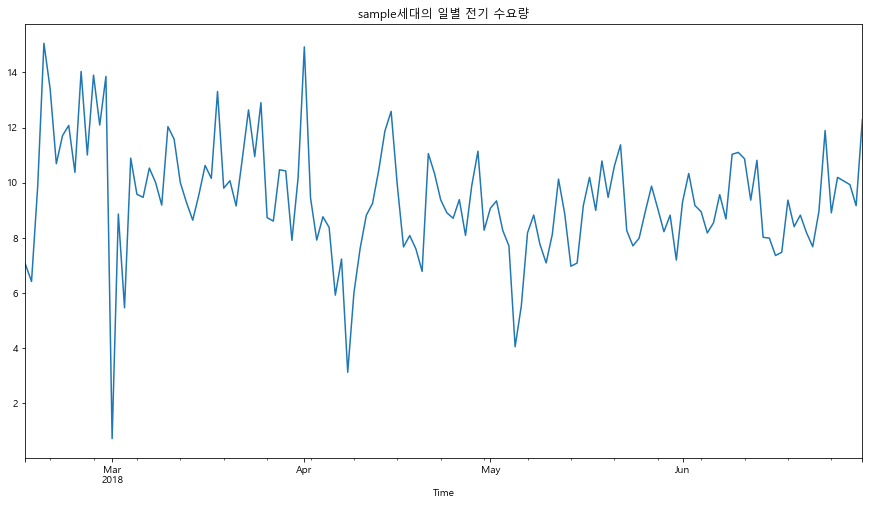

In [14]:
train_day.plot(figsize=(15,8),title="sample세대의 일별 전기 수요량")

In [15]:
## demcopose 함수

def plot_decompose(decomposeresult):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8))
    decomposeresult.observed.plot(legend=False, ax=ax1)
    ax1.set_ylabel('Observed')
    decomposeresult.trend.plot(legend=False, ax=ax2)
    ax2.set_ylabel('Trend')
    decomposeresult.seasonal.plot(legend=False, ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposeresult.resid.plot(legend=False, ax=ax4)
    ax4.set_ylabel('resid')

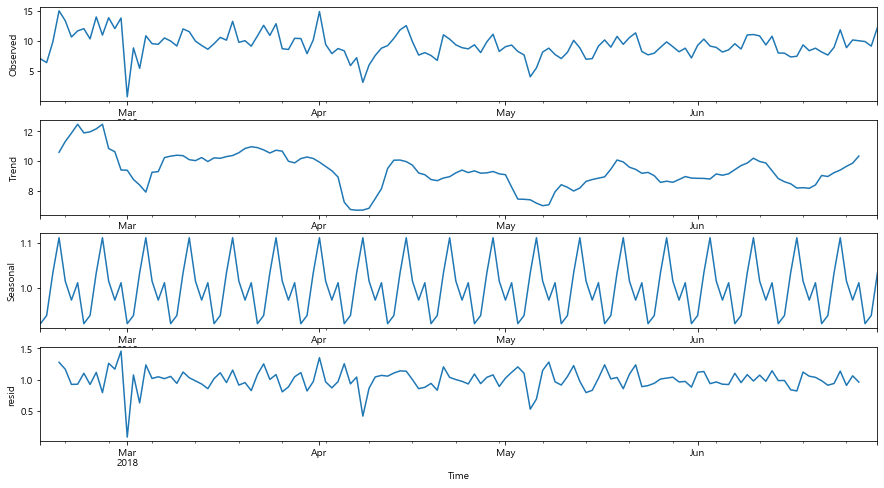

In [16]:
result = seasonal_decompose(train_day, model='multiplicative')
plot_decompose(result)

In [17]:
## differencing

# stationary check def
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else :
        print('Non-Stationary {}'.format(result[1]))

In [18]:
adf_check(train_day) # stationary test

Stationary 1.313110158187331e-11


C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


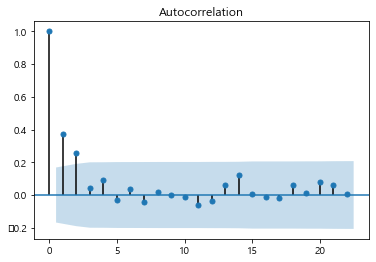

In [19]:
plot_acf(train_day); # AutoCorrelation

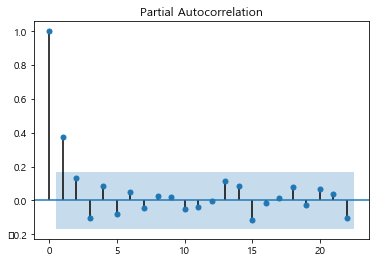

In [20]:
plot_pacf(train_day, method='ywm'); # Partial Autocorrelation

In [21]:
p = list(range(0,5))
d = [0]
q = [0,1]

pdq = list(itertools.product(p,d,q))

In [22]:
for param in pdq:
    model = ARIMA(train_day, order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which

ARIMA(0, 0, 0) => AIC : 591.0540898013213
ARIMA(0, 0, 1) => AIC : 578.5609755070091
ARIMA(1, 0, 0) => AIC : 572.0965197213757
ARIMA(1, 0, 1) => AIC : 572.4294790264222
ARIMA(2, 0, 0) => AIC : 571.487181749131
ARIMA(2, 0, 1) => AIC : 569.8961846179028
ARIMA(3, 0, 0) => AIC : 571.8401493795125
ARIMA(3, 0, 1) => AIC : 574.836281154927
ARIMA(4, 0, 0) => AIC : 573.0897973004613
ARIMA(4, 0, 1) => AIC : 573.8350869188382


In [23]:
X = train_day.values
size = int(len(X)*0.76)
train_sample_1,test_sample_1 = X[:size],X[size:] # train_sample_1 => 앞쪽 23개 

In [24]:
history = [x for x in train_sample_1] # train은 그대로 두고 (복사본 생성)

In [25]:
predictions = []

for t in range(len(test_sample_1)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(1,0,0))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test_sample_1[t] 
    history.append(obs) # 하나씪 범위 늘림

In [26]:
predictions

[array([9.28207046]),
 array([8.94842782]),
 array([9.17641283]),
 array([8.5284912]),
 array([9.34744866]),
 array([9.75387931]),
 array([9.30442888]),
 array([9.21524232]),
 array([8.91034706]),
 array([9.04775837]),
 array([9.4436468]),
 array([9.09901955]),
 array([10.00929128]),
 array([10.05026809]),
 array([9.97218473]),
 array([9.38817127]),
 array([9.95545329]),
 array([8.87264146]),
 array([8.85162674]),
 array([8.59044495]),
 array([8.61922641]),
 array([9.36176403]),
 array([8.98170243]),
 array([9.14216609]),
 array([8.88678774]),
 array([8.67596424]),
 array([9.18000769]),
 array([10.33862704]),
 array([9.17241452]),
 array([9.67087702]),
 array([9.62307185]),
 array([9.57590797]),
 array([9.28128915])]

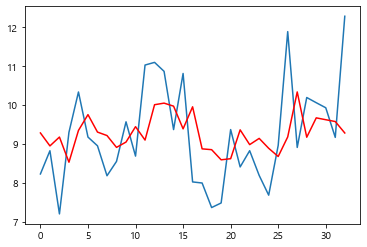

In [27]:
plt.plot(test_sample_1)
plt.plot(predictions,color='red')

In [28]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_sample_1,predictions)

In [29]:
rmse = np.sqrt(error)
rmse

1.2177637825914922

In [30]:
model = sm.tsa.statespace.SARIMAX(train_day,
                                 order=(0,0,1),
                                 seasonal_order=(1,1,1,12))

In [31]:
result = model.fit()

In [32]:
print(result.summary())
# AIC, BIC => 모델의 성능,단순함

                                 Statespace Model Results                                 
Dep. Variable:                              X1272   No. Observations:                  136
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -273.992
Date:                            Thu, 17 Oct 2019   AIC                            555.984
Time:                                    23:27:58   BIC                            567.265
Sample:                                02-15-2018   HQIC                           560.566
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2767      0.077      3.589      0.000       0.126       0.428
ar.S.L12      -0.1275      0.087   

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


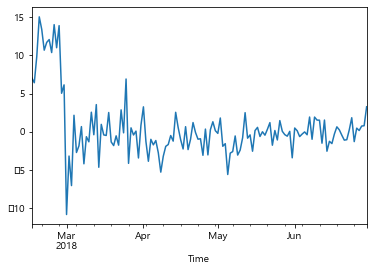

In [33]:
result.resid.plot() # 결과의 residual 보기

In [34]:
train_sample_forecast = result.predict(start=50,end=136,dynamic=True) # 150~168번째 데이터를 예측하라

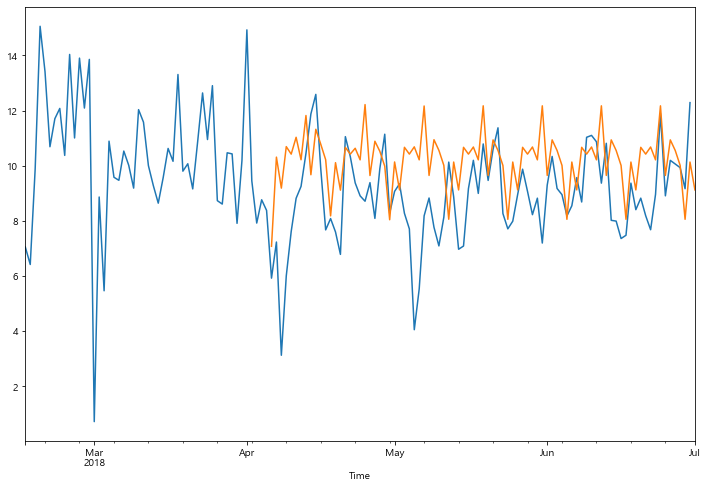

In [35]:
train_day.plot(figsize=(12,8))
train_sample_forecast.plot()

In [36]:
train_sample['X1272'].resample('D').sum()

Time
2018-02-15     7.052000
2018-02-16     6.420000
2018-02-17     9.884000
2018-02-18    15.056000
2018-02-19    13.408000
2018-02-20    10.689000
2018-02-21    11.707000
2018-02-22    12.078000
2018-02-23    10.375000
2018-02-24    14.035000
2018-02-25    11.007000
2018-02-26    13.902000
2018-02-27    12.091250
2018-02-28    13.855417
2018-03-01     0.722333
2018-03-02     8.866000
2018-03-03     5.466667
2018-03-04    10.891333
2018-03-05     9.582000
2018-03-06     9.472000
2018-03-07    10.532000
2018-03-08    10.016000
2018-03-09     9.189000
2018-03-10    12.034000
2018-03-11    11.579000
2018-03-12    10.004000
2018-03-13     9.279000
2018-03-14     8.643000
2018-03-15     9.570000
2018-03-16    10.627000
2018-03-17    10.161000
2018-03-18    13.308000
2018-03-19     9.803000
2018-03-20    10.072000
2018-03-21     9.160000
2018-03-22    10.871000
2018-03-23    12.639000
2018-03-24    10.950000
2018-03-25    12.903000
2018-03-26     8.734000
2018-03-27     8.610000
2018-03-28 

In [37]:
train_day

Time
2018-02-15     7.052000
2018-02-16     6.420000
2018-02-17     9.884000
2018-02-18    15.056000
2018-02-19    13.408000
2018-02-20    10.689000
2018-02-21    11.707000
2018-02-22    12.078000
2018-02-23    10.375000
2018-02-24    14.035000
2018-02-25    11.007000
2018-02-26    13.902000
2018-02-27    12.091250
2018-02-28    13.855417
2018-03-01     0.722333
2018-03-02     8.866000
2018-03-03     5.466667
2018-03-04    10.891333
2018-03-05     9.582000
2018-03-06     9.472000
2018-03-07    10.532000
2018-03-08    10.016000
2018-03-09     9.189000
2018-03-10    12.034000
2018-03-11    11.579000
2018-03-12    10.004000
2018-03-13     9.279000
2018-03-14     8.643000
2018-03-15     9.570000
2018-03-16    10.627000
2018-03-17    10.161000
2018-03-18    13.308000
2018-03-19     9.803000
2018-03-20    10.072000
2018-03-21     9.160000
2018-03-22    10.871000
2018-03-23    12.639000
2018-03-24    10.950000
2018-03-25    12.903000
2018-03-26     8.734000
2018-03-27     8.610000
2018-03-28 

In [38]:
### 기온과 전력수요량의 세대별 상관관계


In [39]:
# 기온 데이터 load
temp = pd.read_csv('C:/Users/KIHyuk/Documents/GitHub/Jupyter_Repo/Data/인천_기상.csv', encoding='euc-kr')

In [40]:
temp

,지점,일시,기온(°C)
0,112,2018-02-15 00:00,-1.0
1,112,2018-02-15 01:00,-1.2
2,112,2018-02-15 02:00,-1.2
3,112,2018-02-15 03:00,-1.5
4,112,2018-02-15 04:00,-1.9
...,...,...,...
3259,112,2018-06-30 19:00,26.5
3260,112,2018-06-30 20:00,24.5
3261,112,2018-06-30 21:00,24.5
3262,112,2018-06-30 22:00,24.1


In [41]:
corr_temp = temp

corr_temp['일시'] = corr_temp['일시'].apply(pd.to_datetime)
corr_temp.set_index('일시',inplace=True)
del corr_temp['지점']

corr_temp[['X692','X1272', 'X553', 'X1299', 'X598', 'X1003', 'X1010', 'X1216','X1047']] = (train_sample[['X692','X1272', 'X553', 'X1299', 'X598', 'X1003', 'X1010', 'X1216','X1047']]*10)

In [42]:
corr_temp.head()

,기온(°C),X692,X1272,X553,X1299,X598,X1003,X1010,X1216,X1047
일시,,,,,,,,,,
2018-02-15 00:00:00,-1.0,1.50,3.92,1.81,2.37,0.64,2.31,2.53,2.89,1.07
2018-02-15 01:00:00,-1.2,4.22,8.73,5.02,3.56,1.60,3.65,4.06,2.67,2.09
2018-02-15 02:00:00,-1.2,3.14,4.40,4.61,3.08,1.74,3.41,4.00,2.79,1.92
2018-02-15 03:00:00,-1.5,3.09,2.92,5.24,2.79,1.98,3.43,3.93,2.72,1.42
2018-02-15 04:00:00,-1.9,3.27,2.98,4.86,3.64,1.55,3.88,3.88,2.73,1.42


In [43]:
corr_temp.corr()

,기온(°C),X692,X1272,X553,X1299,X598,X1003,X1010,X1216,X1047
기온(°C),1.000000,-0.004171,-0.118745,0.121565,-0.297520,0.062871,-0.173174,0.004745,0.060694,0.041040
X692,-0.004171,1.000000,0.200442,0.121019,0.147869,0.206926,0.325063,0.306885,0.276297,0.259149
X1272,-0.118745,0.200442,1.000000,0.202018,0.384751,0.454679,0.394469,0.290458,0.224891,0.244428
X553,0.121565,0.121019,0.202018,1.000000,0.220809,0.332229,0.232264,0.156484,0.185150,0.205895
X1299,-0.297520,0.147869,0.384751,0.220809,1.000000,0.312709,0.269594,0.178622,0.147556,0.125074
X598,0.062871,0.206926,0.454679,0.332229,0.312709,1.000000,0.427486,0.300028,0.248009,0.311231
X1003,-0.173174,0.325063,0.394469,0.232264,0.269594,0.427486,1.000000,0.286980,0.296837,0.324216
X1010,0.004745,0.306885,0.290458,0.156484,0.178622,0.300028,0.286980,1.000000,0.257257,0.164016
X1216,0.060694,0.276297,0.224891,0.185150,0.147556,0.248009,0.296837,0.257257,1.000000,0.331222
X1047,0.041040,0.259149,0.244428,0.205895,0.125074,0.311231,0.324216,0.164016,0.331222,1.000000


In [44]:
## test 데이터셋

In [45]:
test.shape

(8760, 201)

In [46]:
test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

In [47]:
test.head()

,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,X160,X125,X211,X349,X407,X330,X132,X231,X225,X16,X286,X354,X353,X76,X255,X106,X393,X157,X323,X130,X269,X94,X172,X289,X216,X123,X398,X233,X214,X270,X371,X200,X111,X163,X364,X378,X271,X462,X427,X73,X7,X263,X450,X18,X206,X133,X41,X195,X155,X134,X297,X175,X254,X196,X481,X412,X337,X406,X67,X414,X55,X91,X260,X252,X5,...,X178,X308,X217,X229,X358,X31,X148,X397,X363,X165,X30,X88,X296,X219,X116,X68,X431,X302,X314,X124,X405,X315,X51,X176,X396,X449,X383,X473,X205,X35,X161,X403,X341,X149,X82,X377,X232,X333,X140,X44,X37,X42,X422,X50,X386,X80,X250,X142,X235,X446,X331,X102,X186,X243,X194,X183,X139,X459,X457,X70,X368,X282,X426,X47,X192,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.273,NaN,0.385,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.305,NaN,NaN,NaN,NaN,NaN,NaN,0.109,NaN,NaN,NaN,NaN,NaN,NaN,0.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.870,NaN,NaN,0.140,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137,NaN,NaN,0.243,2.181,NaN,NaN,NaN,0.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.860,NaN,NaN,NaN,NaN,NaN,0.469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
2017-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166,NaN,0.401,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.308,NaN,NaN,NaN,NaN,NaN,NaN,0.143,NaN,NaN,NaN,NaN,NaN,NaN,0.052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465,NaN,NaN,0.136,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121,NaN,NaN,0.299,2.121,NaN,NaN,NaN,0.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.792,NaN,NaN,NaN,NaN,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2017-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164,NaN,0.409,NaN,NaN,NaN,NaN,NaN,0.092,NaN,NaN,NaN,0.344,NaN,NaN,NaN,NaN,NaN,NaN,0.130,NaN,NaN,NaN,NaN,NaN,NaN,0.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.325,NaN,NaN,0.153,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121,NaN,NaN,0.238,1.584,NaN,NaN,NaN,0.143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.837,NaN,NaN,NaN,NaN,NaN,0.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
2017-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168,NaN,0.431,NaN,NaN,NaN,NaN,NaN,0.092,NaN,NaN,NaN,0.312,NaN,NaN,NaN,NaN,NaN,NaN,0.114,NaN,NaN,NaN,NaN,NaN,NaN,0.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.414,NaN,NaN,0.152,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.121,NaN,NaN,0.228,2.252,NaN,NaN,NaN,0.144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.245,NaN,NaN,NaN,NaN,NaN,0.501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
2017-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196,NaN,0.353,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.306,NaN,NaN,NaN,NaN,NaN,NaN,0.133,NaN,NaN,NaN,NaN,NaN,NaN,0.073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.389,NaN,NaN,0.152,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.126,NaN,NaN,0.170,2.341,NaN,NaN,NaN,0.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

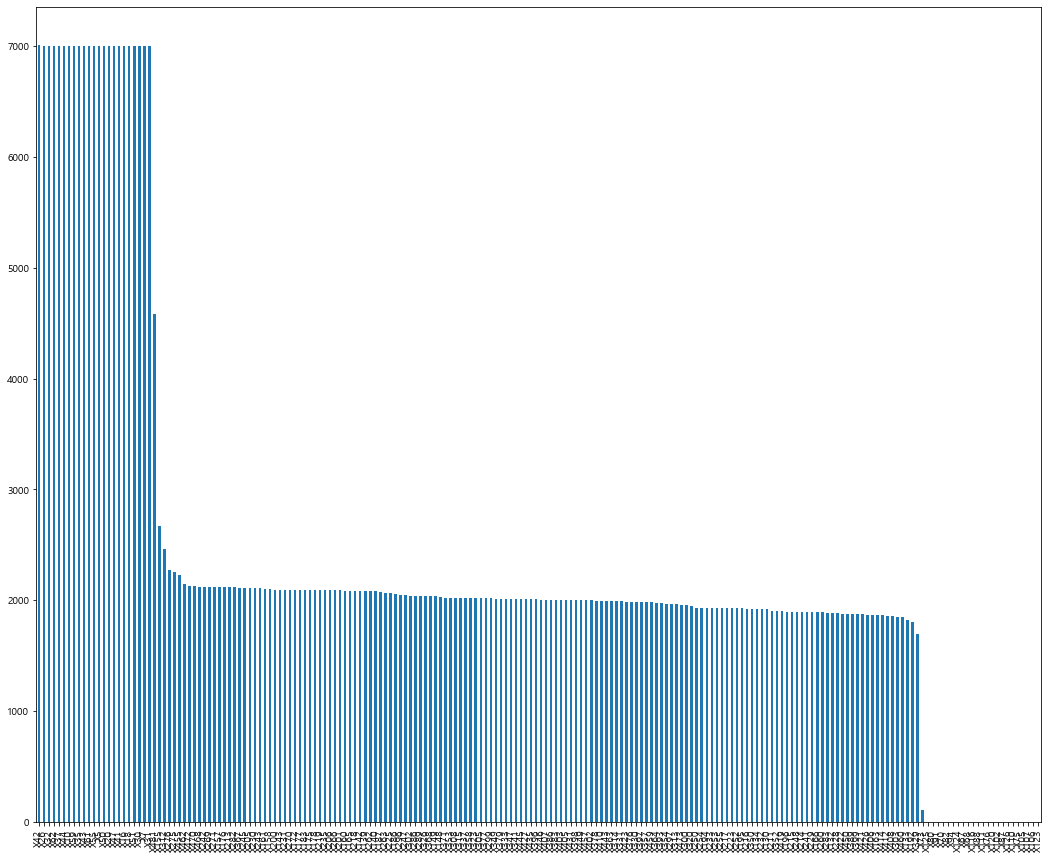

In [48]:
test.isnull().sum().sort_values(ascending=False).plot(kind='bar',figsize=(18,15))

In [49]:
## 결측치가 없는
test.loc[:,test.isnull().sum()==0]

,X125,X76,X106,X94,X123,X111,X67,X91,X87,X126,X120,X110,X105,X88,X116,X68,X124,X82,X80,X102,X70,X75,X107
Time,,,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,0.226,0.273,0.385,0.093,0.305,0.109,0.870,0.140,1.231,0.038,0.313,0.140,0.212,0.137,0.243,2.181,0.145,0.369,12.860,0.469,0.175,0.275,0.021
2017-07-01 01:00:00,0.223,0.166,0.401,0.093,0.308,0.143,0.465,0.136,0.412,0.038,0.321,0.068,0.187,0.121,0.299,2.121,0.144,0.303,12.792,0.477,0.165,0.222,0.021
2017-07-01 02:00:00,0.216,0.164,0.409,0.092,0.344,0.130,0.325,0.153,0.332,0.038,0.373,0.092,0.168,0.121,0.238,1.584,0.143,0.335,12.837,0.483,0.157,0.237,0.021
2017-07-01 03:00:00,0.224,0.168,0.431,0.092,0.312,0.114,0.414,0.152,0.320,0.038,0.406,0.065,0.203,0.121,0.228,2.252,0.144,0.323,11.245,0.501,0.164,0.229,0.020
2017-07-01 04:00:00,0.303,0.196,0.353,0.093,0.306,0.133,0.389,0.152,0.392,0.039,0.420,0.072,0.177,0.126,0.170,2.341,0.145,0.323,4.813,0.448,0.177,0.202,0.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-30 19:00:00,0.184,1.556,0.355,0.003,0.448,0.166,0.446,0.303,0.369,0.039,0.217,0.062,0.174,0.125,0.155,1.926,0.191,0.291,13.825,1.702,0.990,3.519,0.027
2018-06-30 20:00:00,0.187,1.008,0.347,0.003,0.451,0.107,0.528,0.358,0.294,0.039,0.494,0.119,0.176,0.122,0.093,1.509,0.191,0.336,13.570,0.468,0.420,3.331,0.027
2018-06-30 21:00:00,0.173,1.690,0.363,0.003,0.462,0.181,0.434,0.345,0.382,0.039,0.497,0.075,0.213,0.125,0.137,1.806,0.192,0.319,12.862,0.354,0.135,3.416,0.026


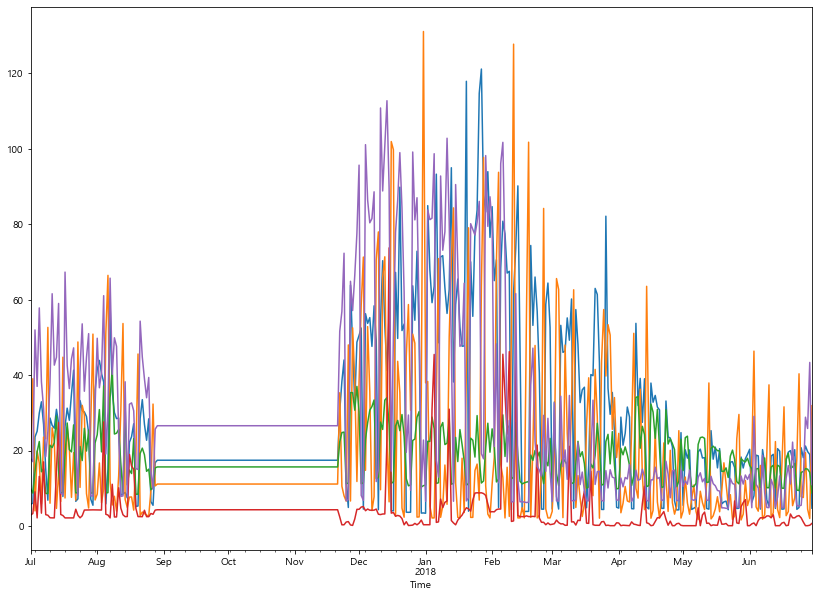

In [50]:
test['X125'].resample(rule='D').sum().plot(figsize=(14,10))
test['X76'].resample(rule='D').sum().plot(figsize=(14,10))
test['X106'].resample(rule='D').sum().plot(figsize=(14,10))
test['X94'].resample(rule='D').sum().plot(figsize=(14,10))
test['X123'].resample(rule='D').sum().plot(figsize=(14,10))



In [51]:
## 테스트데이터(결측치없는 데이터) 기반 모델 생성

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 432x288 with 0 Axes>

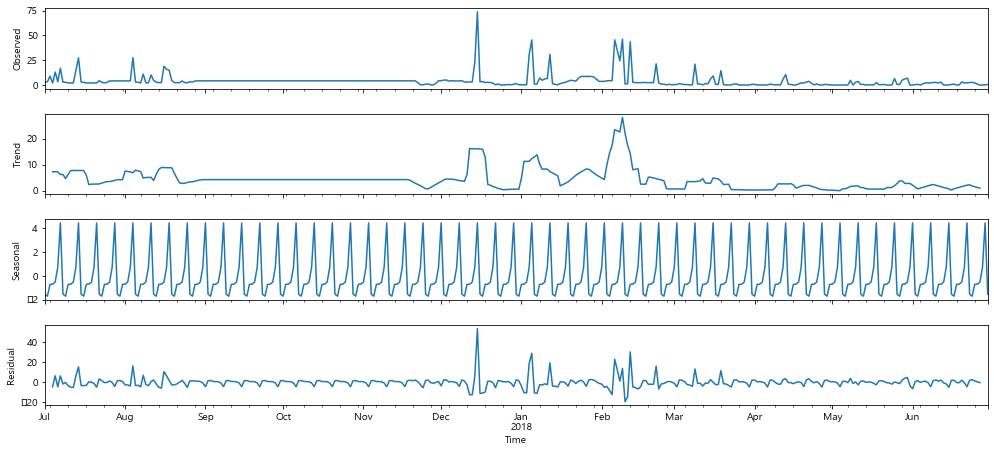

In [52]:
# decompositon
# 'X94' 세대를 샘플로

test_sample = test['X94'].resample('D').sum()

decomposition = seasonal_decompose(test_sample)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

In [53]:
test_sample_1stDiff = test_sample - test_sample.shift(1)

In [54]:
adf_check(test_sample_1stDiff.dropna())

Stationary 1.3264648800173514e-13


In [55]:
test_sample_2ndDiff = test_sample_1stDiff - test_sample_1stDiff.shift(1)

In [56]:
adf_check(test_sample_2ndDiff.dropna())

Stationary 4.528124435796644e-17


In [57]:
p = list(range(0,5))
d = [1,2]
q = [0]

pdq = list(itertools.product(p,d,q))

In [58]:
for param in pdq:
    model = ARIMA(test_sample, order=param)
    result = model.fit(disp=0)
    print('ARIMA{} => AIC : {}'.format(param,result.aic))

ARIMA(0, 1, 0) => AIC : 2596.1064654254583
ARIMA(0, 2, 0) => AIC : 2950.2488767211025
ARIMA(1, 1, 0) => AIC : 2550.9735331663287
ARIMA(1, 2, 0) => AIC : 2818.117283711892
ARIMA(2, 1, 0) => AIC : 2501.7192261522787


C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which

ARIMA(2, 2, 0) => AIC : 2691.701336715779
ARIMA(3, 1, 0) => AIC : 2499.5956055434226
ARIMA(3, 2, 0) => AIC : 2656.961294856588
ARIMA(4, 1, 0) => AIC : 2487.8561482997884
ARIMA(4, 2, 0) => AIC : 2628.160534976426


In [59]:
# train ,test split
X = test_sample.values
size = int(len(X)*0.66)
train_tar,test_tar = X[:size],X[size:] # train => 앞쪽 23개 

In [60]:
history = [x for x in train_tar] # train은 그대로 두고 (복사본 생성)

In [61]:
predictions = []

for t in range(len(test_tar)): # test사이즈만큼 prediction
    model = ARIMA(history, order=(4,1,0))
    result = model.fit(disp=0) # disp=0 => warnning메세지 안뜨게
    output = result.forecast() # forcast default인자는 1임 # 즉, 다음거 하나만 예측 # 배열로 저장됨
    yhat = output[0] # yhat => 예측값
    predictions.append(yhat)
    
    # 계속해서 다음꺼 예측하기 위해
    obs = test_tar[t] 
    history.append(obs) # 하나씪 범위 늘림

In [62]:
predictions

[array([1.59890444]),
 array([4.71464174]),
 array([1.04841862]),
 array([0.43475618]),
 array([0.60693126]),
 array([0.42300777]),
 array([1.01257344]),
 array([0.67864399]),
 array([0.79508563]),
 array([0.62362634]),
 array([0.52360885]),
 array([0.38988112]),
 array([10.26714275]),
 array([1.50932545]),
 array([6.77230234]),
 array([0.63174565]),
 array([5.18038789]),
 array([0.98275824]),
 array([3.58091014]),
 array([5.10406905]),
 array([2.80832447]),
 array([3.32636712]),
 array([8.3405749]),
 array([2.77434727]),
 array([4.4761565]),
 array([0.46173872]),
 array([2.90201544]),
 array([0.59471964]),
 array([0.64770622]),
 array([0.42275577]),
 array([0.44840739]),
 array([0.26141668]),
 array([0.28053364]),
 array([0.03980921]),
 array([0.4121482]),
 array([0.39270288]),
 array([0.28353944]),
 array([0.29802531]),
 array([0.22517622]),
 array([0.22079992]),
 array([0.05715836]),
 array([0.53572939]),
 array([0.28725196]),
 array([0.48637933]),
 array([0.23399462]),
 array([0.34

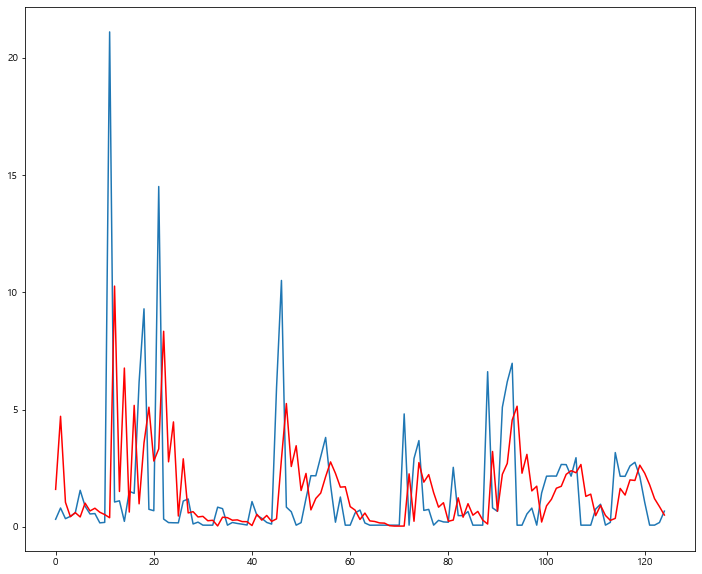

In [63]:
plt.figure(figsize=(12,10))
plt.plot(test_tar)
plt.plot(predictions,color='red')

In [64]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_tar,predictions)

In [65]:
rmse = np.sqrt(error)
rmse

3.142887619312147

In [66]:
test_sample.describe()

count    365.000000
mean       4.287866
std        7.327680
min        0.071000
25%        0.803000
50%        2.949000
75%        4.296000
max       73.719000
Name: X94, dtype: float64

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=5000,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

In [67]:
lgbm_fit = model.fit(train_tar,test_tar)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:396: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif exog is not None and trend == 'c':  # constant plus exogenous
C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:398: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif exog is not None and trend == 'nc':
C:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:403: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if trend == 'nc':
C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


LinAlgError: SVD did not converge